### 加载数据

In [1]:
import tensorflow as tf
from keras import backend as K

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3" # GPU 列表

G = 4 # GPU 数量
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options, allow_soft_placement=True))
K.set_session(session)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import numpy as np
train_q = np.load('data/train_q.npy')
train_a = np.load('data/train_a.npy')
train_y = np.load('data/train_y.npy')
test_q = np.load('data/test_q.npy')
test_a = np.load('data/test_a.npy')
test_y = np.load('data/test_y.npy')
test_id = np.load('data/test_id.npy')

### 网络结构

In [3]:
%load_ext autoreload
%autoreload 2
from models import *

model = Attention()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     55470100    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     55470100    input_54[0][0]                   
__________________________________________________________________________________________________
model_18 (

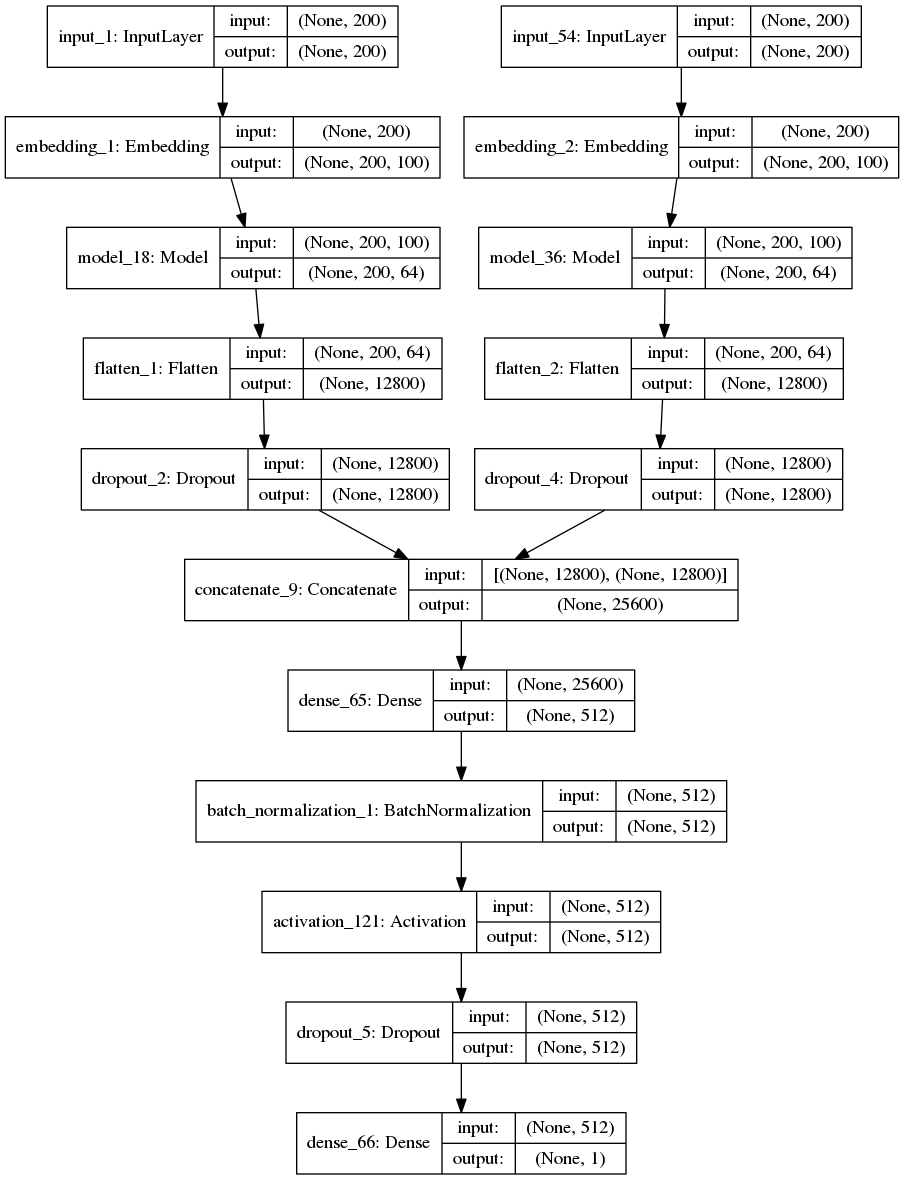

In [4]:
# 模型可视化 https://keras-cn.readthedocs.io/en/latest/other/visualization/
from keras.utils import plot_model
from IPython import display

# pip install pydot=1.2.3
# pip install pydot-ng
# sudo apt-get install graphviz
plot_model(model, to_file="img/Attention.png", show_shapes=True)
display.Image('img/Attention.png')

### 训练

In [5]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.utils import multi_gpu_model

EPOCHS = 10
BATCH_SIZE = 64 * G
VALIDATION_SPLIT = 0.3 # 30% 验证集

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_path = 'model/Attention.h5'
model_checkpoint = ModelCheckpoint(model_path, save_best_only=True, save_weights_only=True)
tensorboard = TensorBoard('log/Attention', write_graph=True, write_images=True)

model = multi_gpu_model(model)

model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

model.fit([train_q, train_a], train_y, epochs=EPOCHS, batch_size=BATCH_SIZE, 
          validation_split=VALIDATION_SPLIT, shuffle=True, 
          callbacks=[early_stopping, model_checkpoint, tensorboard])

Train on 333913 samples, validate on 143106 samples
Epoch 1/10
333913/333913 [==============================] - 3415s 10ms/step - loss: 0.5383 - acc: 0.7399 - val_loss: 0.4927 - val_acc: 0.7586
Epoch 2/10
333913/333913 [==============================] - 3411s 10ms/step - loss: 0.4663 - acc: 0.7729 - val_loss: 0.4855 - val_acc: 0.7528
Epoch 3/10
333913/333913 [==============================] - 3397s 10ms/step - loss: 0.4318 - acc: 0.7925 - val_loss: 0.4736 - val_acc: 0.7675
Epoch 4/10
333913/333913 [==============================] - 3396s 10ms/step - loss: 0.4032 - acc: 0.8094 - val_loss: 0.4846 - val_acc: 0.7724
Epoch 5/10
333913/333913 [==============================] - 3396s 10ms/step - loss: 0.3812 - acc: 0.8213 - val_loss: 0.4796 - val_acc: 0.7726
Epoch 6/10
333913/333913 [==============================] - 3399s 10ms/step - loss: 0.3623 - acc: 0.8314 - val_loss: 0.4984 - val_acc: 0.7728
Epoch 7/10
333913/333913 [==============================] - 3395s 10ms/step - loss: 0.3471 - acc

### 预测

In [6]:
y_true = []
with open('data/submit_sample.txt', 'r') as f:
    for line in f.readlines():
        pro = line.strip().split(',')
        y_true.append(int(pro[1]))

In [7]:
# load the best model
model_path = 'model/Attention.h5'
model.load_weights(model_path)
predicts = model.predict([test_q, test_a], batch_size=64, verbose=1)

with open('predict/Attention.txt', 'w') as f:
    for i in range(len(test_id)):
        f.write('%d,%s\n' % (test_id[i], predicts[i][0]))

num = 0
for i in range(len(y_true)):
    if y_true[i] == 0 and predicts[i][0] < 0.5: num += 1
    if y_true[i] == 1 and predicts[i][0] >= 0.5: num += 1
print('%d / %d = %f' % (num, len(y_true), num / len(y_true)))

1586/1586 [==============================] - 14s 9ms/step
1231 / 1586 = 0.776166
